In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
pip install pyspark

     |████████████████████████████████| 217.8MB 22kB/s 
     |████████████████████████████████| 204kB 55.4MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=40521dfd0f7e066546d9c0c83e9a1d92c7c2704665633a74cee31865da6ead2e
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
import time
import os
import math
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()

sc = spark.sparkContext

In [0]:
data_path = '/content/drive/My Drive/ml-latest-small/'
movies = spark.read.load(os.path.join(data_path, 'movies.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)
links = spark.read.load(os.path.join(data_path, 'links.csv'), format='csv', header=True, inferSchema=True)
tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True, inferSchema=True)

In [0]:
movie_rating = sc.textFile(os.path.join(data_path, 'ratings.csv'))
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()


In [0]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
train.cache()
validation.cache()
test.cache()

PythonRDD[46] at RDD at PythonRDD.scala:53

In [0]:

def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           
                seed=99)
          
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
          
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
          
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [0]:
num_iterations = 10
ranks = [10, 12, 14, 16, 18, 20]
reg_params = [0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

10 latent factors and regularization = 0.01: validation RMSE is 1.1997655036811583
10 latent factors and regularization = 0.05: validation RMSE is 0.9946714474591942
10 latent factors and regularization = 0.1: validation RMSE is 0.9139057402588864
10 latent factors and regularization = 0.2: validation RMSE is 0.8922184864535349
12 latent factors and regularization = 0.01: validation RMSE is 1.2199803124948976
12 latent factors and regularization = 0.05: validation RMSE is 0.9934409924050976
12 latent factors and regularization = 0.1: validation RMSE is 0.9105980441631525
12 latent factors and regularization = 0.2: validation RMSE is 0.8915968568036029
14 latent factors and regularization = 0.01: validation RMSE is 1.253684022139703
14 latent factors and regularization = 0.05: validation RMSE is 1.0000377913982483
14 latent factors and regularization = 0.1: validation RMSE is 0.9096210171148031
14 latent factors and regularization = 0.2: validation RMSE is 0.8912747068649134
16 latent f

In [0]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,   
            iterations=num_iters,
            rank=rank,
            lambda_=reg,          
            seed=99)
        
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        
        errors.append(error)


    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

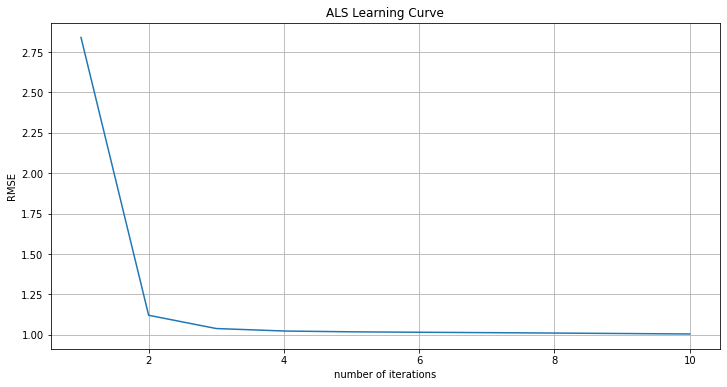

In [0]:
iter_array = list(range(1, 11))
plot_learning_curve(iter_array, train, validation, 0.05, 20)

In [0]:
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9009


In [0]:
def get_movieId(df_movies, fav_movie_list):  
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    new_id = train_data.map(lambda r: r[0]).max() + 1
    max_rating = train_data.map(lambda r: r[2]).max()
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    new_id = train_data.map(lambda r: r[0]).max() + 1
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)
    
    
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)
    
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    return df_movies.filter(movies.movieId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

In [0]:
my_favorite_movies = ['Dark Knight']

recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 14, 'lambda_': 0.2}, 
    ratings_data=rating_data, 
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Dark Knight:
1: On the Beach (1959)
2: The Big Bus (1976)
3: Saving Face (2004)
4: Visitor, The (2007)
5: Frozen River (2008)
6: Strictly Sexual (2008)
7: Dylan Moran: Monster (2004)
8: Bill Hicks: Revelations (1993)
9: Seve (2014)
10: Deathgasm (2015)
